# Задание по линейной регрессии

## Загрузка данных и первичный анализ

In [142]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,RidgeCV, LassoCV, ElasticNetCV
warnings.filterwarnings("ignore")

In [143]:
df = pd.read_csv('AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [144]:
df = df.drop(columns = ['id', 'name', 'host_id', 'host_name', 'last_review'])

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               38843 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 4.1+ MB


In [146]:
df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [147]:
df.describe(include=["O"])

,neighbourhood_group,neighbourhood,room_type
count,48895,48895,48895
unique,5,221,3
top,Manhattan,Williamsburg,Entire home/apt
freq,21661,3920,25409


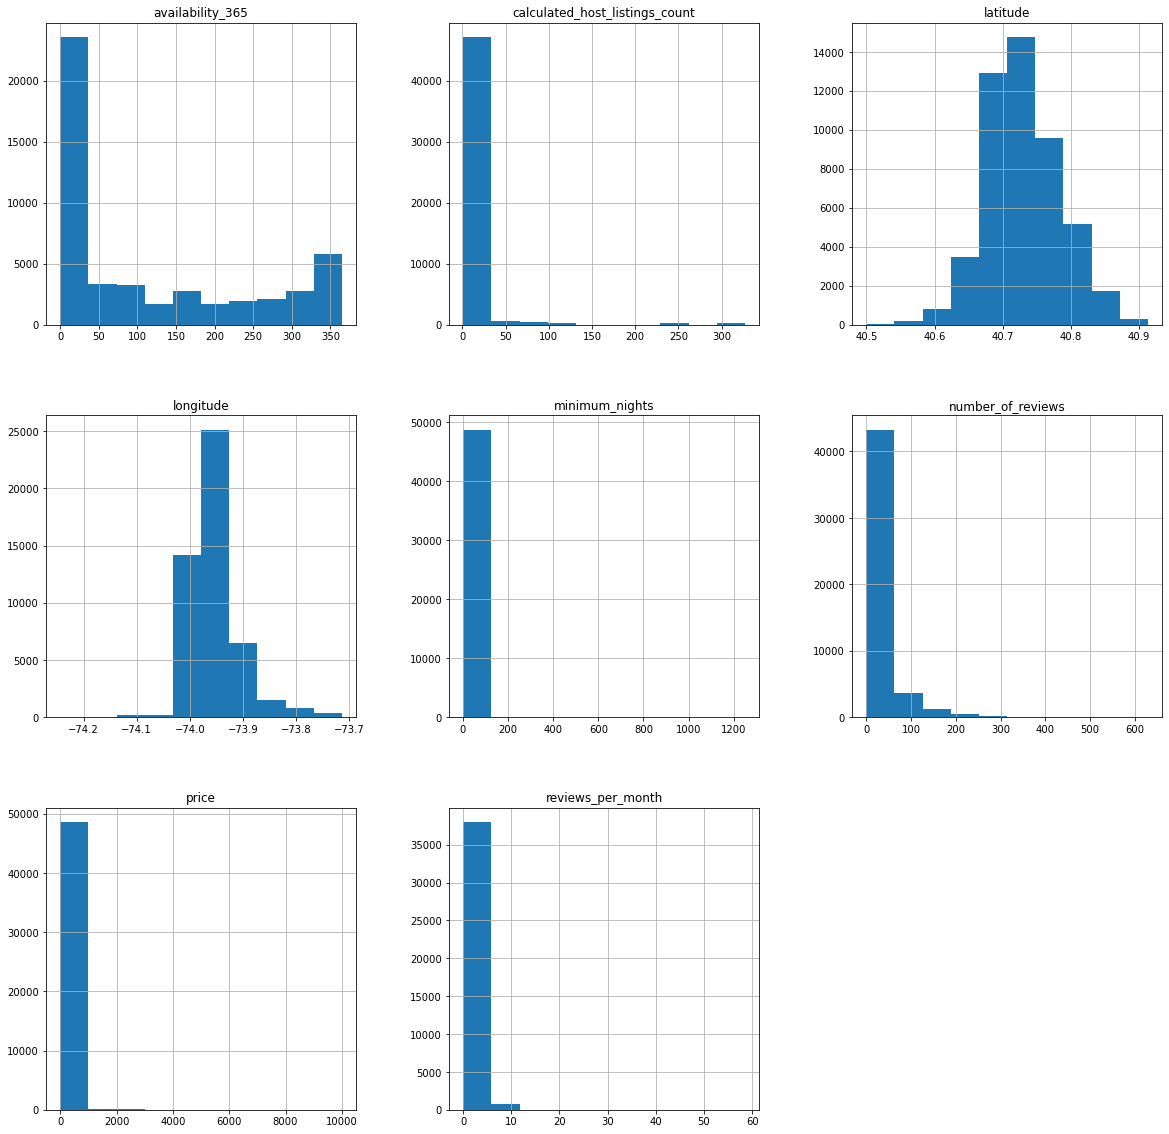

In [148]:
df.hist(figsize=(20, 20));

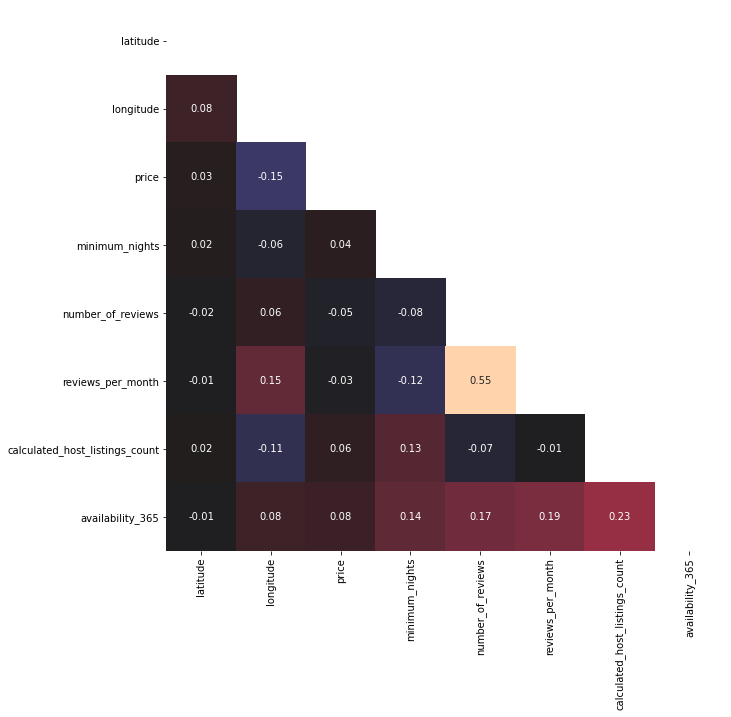

In [149]:
plt.figure(figsize=(10,10))

corr_matrix = df.corr()
lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

sns.heatmap(lower, annot=True, fmt='.2f', cbar=False, center=0);

In [150]:
# заполняю пустые значения медианой
df.reviews_per_month = df.reviews_per_month.fillna(df.reviews_per_month.median())

In [174]:
# найжем расстояние до центра Нью-Йорка
# Подумал, что Эвклидово расстояние считать не слишком корректно, поэтому посчитал расстонияе c учетом кривизны Земли
from geopy import distance


def distance_to_center_NY(lat_long):
    centr_NY = [40.7142700,-74.0059700]
    return distance.GreatCircleDistance(lat_long, centr_NY).km
df['lat_long']= (df['latitude'].astype('str') +', ' + df['longitude'].astype('str'))
df['distance'] = df['lat_long'].apply(lambda r: (distance_to_center_NY(r)))

In [175]:
# видно, что корреляция между ценой и расстоянием до центра несущесвенная
df[['price','distance']].corr().iloc[0][1]

-0.1501663142440186

In [181]:
# но на грфике рассеяния видно, что чем дальше квартира от центра, тем меньше высоких цен

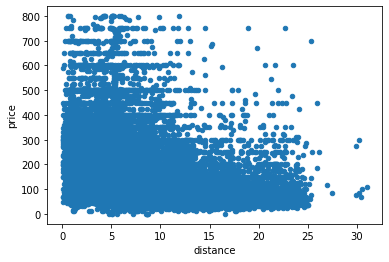

In [166]:
df[df['price']<=df['price'].quantile(0.99)].plot(x ='distance', y = 'price', kind = 'scatter')

In [183]:
# по тепловой карте рапрделения медианы цен можно лучше понять причины такого поведения цены
# видно, что есть несколько областей, удаленных от центра, но с выоскоми ценами
# очевидно, что для более корректного построения географических признков, нужно провести класетризацию по координатам,
# но это видимо задача следующих задач :)

In [90]:
from folium.plugins import HeatMap
centr_NY = [40.7142700,-74.0059700]
map3 = folium.Map(location=centr_NY, tiles='CartoDB dark_matter', zoom_start=11)
df['r_latitude'] = df['latitude'].round(4)
df['r_longitude'] = df['longitude'].round(4)
df_map = df[['r_latitude', 'r_longitude', 'price']].groupby(['r_latitude', 'r_longitude']).median().reset_index().values.tolist()
HeatMap(data=df_map, radius=8, max_zoom=13).add_to(map3)
folium.Marker(centr_NY).add_to(map3)
map3

In [189]:
# функция для преобразования категориальных признаков
def get_dummies(df):
    return pd.get_dummies(df[df.select_dtypes('object').columns])

In [185]:
# функция для скалиарования числовых признаков
def get_scaler(df):
    scaler = StandardScaler()
    cols = df.select_dtypes(exclude=['object']).columns
    return pd.DataFrame(scaler.fit_transform(df[cols]),columns = cols)
#     return scaler.transform([df.select_dtypes(exclude=['object']).columns])

In [187]:
# функция для выравнивания кол-во признаков в тестовой и тренировочной выборке
def columns_update(df1, df2):
    cols_x = list(set(df2.columns.values.tolist()) - set(df1.columns.values.tolist()))
    cols_y = list(set(df1.columns.values.tolist()) - set(df2.columns.values.tolist()))
    for col in cols_x:
        df1[col] = 0
    for col in cols_y:
        df2[col] = 0
    return df1,df2

In [192]:
X.head(2)

,neighbourhood_group,neighbourhood,room_type,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,Brooklyn,Kensington,Private room,1,9,0.21,6,365,7.947789
1,Manhattan,Midtown,Entire home/apt,1,45,0.38,2,355,4.758581


In [190]:
# удаляю лишние столбцы для формирования тестовой и обучающих выборок
X = df.drop(columns  = ['price','latitude','longitude','lat_long','distance_m']).copy()
y = df.price.copy()

In [198]:
# разделение на обучающую и тестовую выборки, обработка признаков
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train_1 = get_scaler(X_train)
X_train_2 = get_dummies(X_train)
X_test_1 = get_scaler(X_test)
X_test_2 = get_dummies(X_test)

X_train_2, X_test_2 = columns_update(X_train_2,X_test_2)

X_train_upd = np.hstack([X_train_1.values,X_train_2.values ])
X_test_upd = np.hstack([X_test_1.values,X_test_2.values ])
cols_ = (X_test_1.columns.values.tolist()) + (X_test_2.columns.values.tolist())


X_train.shape, X_test.shape,X_train_upd.shape,X_test_upd.shape

((34226, 9), (14669, 9), (34226, 235), (14669, 235))


MSE: 70089688344201435256193024.0000


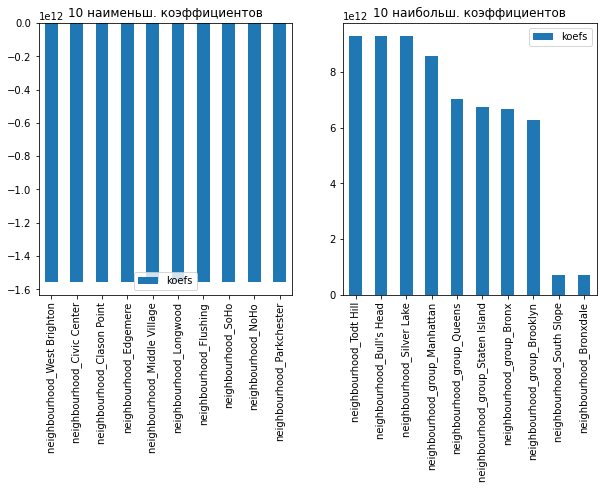

In [199]:
# обучение модели простой линейной регрессии и анализ рещультатов
lin_reg = LinearRegression()
lin_reg.fit(X_train_upd, y_train)
y_pred = lin_reg.predict(X_test_upd)

print("\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test)))

df_koefs = pd.DataFrame(lin_reg.coef_, columns = ['koefs'])
df_koefs.index = cols_
fig, axs = plt.subplots(1,2, figsize=(10, 5))
df_koefs.sort_values(by = 'koefs').head(10).plot(kind = 'bar',ax = axs[0], title = '10 наименьш. коэффициентов')
df_koefs.sort_values(by = 'koefs', ascending = False).head(10).plot(kind = 'bar',ax = axs[1], title = '10 наибольш. коэффициентов')

In [200]:
# Вывод: ошибка модели астрономическая из-за больших коэфффииентов категориальных признаков


MSE: 39137.4776


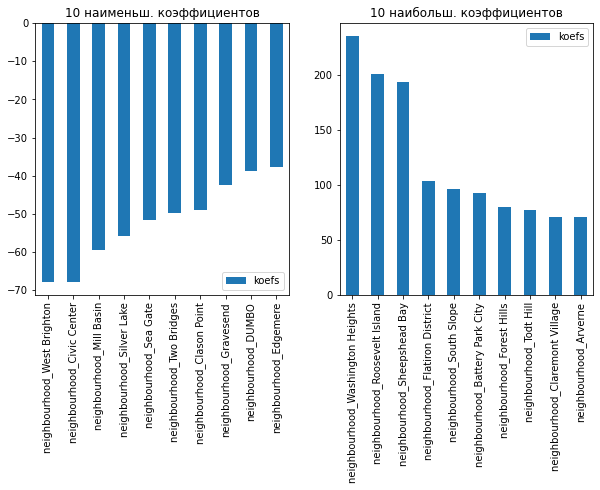

In [201]:
# обучение модели RidgeCV линейной регрессии и анализ рещультатов
lin_reg = RidgeCV()
lin_reg.fit(X_train_upd, y_train)
y_pred = lin_reg.predict(X_test_upd)

print("\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test)))

df_koefs = pd.DataFrame(lin_reg.coef_, columns = ['koefs'])
df_koefs.index = cols_
fig, axs = plt.subplots(1,2, figsize=(10, 5))
df_koefs.sort_values(by = 'koefs').head(10).plot(kind = 'bar',ax = axs[0], title = '10 наименьш. коэффициентов')
df_koefs.sort_values(by = 'koefs', ascending = False).head(10).plot(kind = 'bar',ax = axs[1], title = '10 наибольш. коэффициентов')

In [202]:
# Вывод: ошибка модели на несколько порядков меньше,сработала L2-регулеризация,
# но коэфффииенты категориальных признаков все еще слишком большие


MSE: 41588.6705


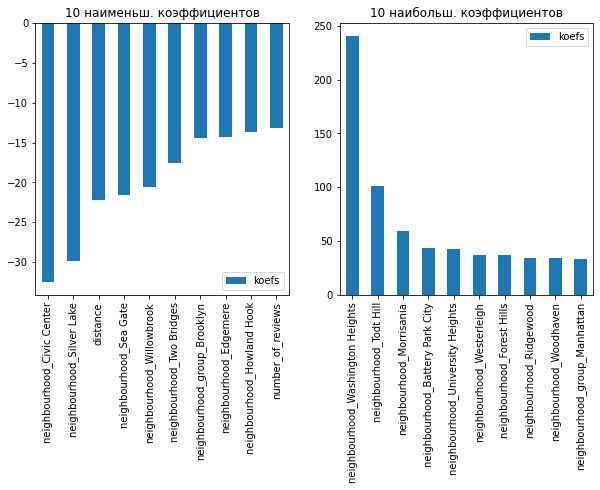

In [203]:
# обучение модели LassoCV линейной регрессии и анализ рещультатов
lin_reg = LassoCV()
lin_reg.fit(X_train_upd, y_train)
y_pred = lin_reg.predict(X_test_upd)

print("\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test)))

df_koefs = pd.DataFrame(lin_reg.coef_, columns = ['koefs'])
df_koefs.index = cols_
fig, axs = plt.subplots(1,2, figsize=(10, 5))
df_koefs.sort_values(by = 'koefs').head(10).plot(kind = 'bar',ax = axs[0], title = '10 наименьш. коэффициентов')
df_koefs.sort_values(by = 'koefs', ascending = False).head(10).plot(kind = 'bar',ax = axs[1], title = '10 наибольш. коэффициентов')

In [205]:
# Вывод: ошибка модели относительно Lasso выросла, но коэффиценты модели значительно меньше,
# сработала L1-регулеризация, которая занулила часть переобученных коэффциентов.
# Наконец-то в топе появился 1 синтетиеский и некотегорианый признак - "раастояние", причем с логически правильным знаком


MSE: 37997.4440


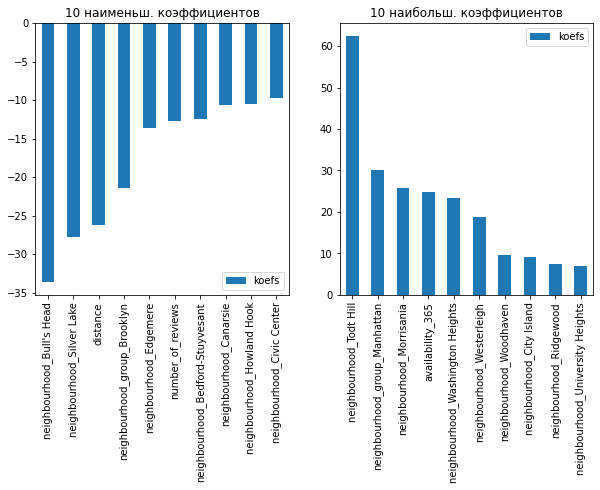

In [206]:
# обучение модели ElasticNetCV линейной регрессии и анализ рещультатов
lin_reg = ElasticNetCV()
lin_reg.fit(X_train_upd, y_train)
y_pred = lin_reg.predict(X_test_upd)

print("\nMSE: {:.4f}".format(mean_squared_error(y_pred, y_test)))

df_koefs = pd.DataFrame(lin_reg.coef_, columns = ['koefs'])
df_koefs.index = cols_
fig, axs = plt.subplots(1,2, figsize=(10, 5))
df_koefs.sort_values(by = 'koefs').head(10).plot(kind = 'bar',ax = axs[0], title = '10 наименьш. коэффициентов')
df_koefs.sort_values(by = 'koefs', ascending = False).head(10).plot(kind = 'bar',ax = axs[1], title = '10 наибольш. коэффициентов')

In [207]:
# Вывод: эта модель является наилучшей по значению ошибки и значению коэффициентов
# за счет использьзования одновременно L1 и L2 регулиризации в алгоритме модели

### В целом в процессе работы удалось уменьшить ощибку и коэффициенты модели. Но полученные результаты все еще не позволяют считать модель рабочей так как наиболее значимыми коэффициентам модели по сути является только один признак - близость к тем или иным местам Нью-Йорка. Мне кажется, что это вызвано в значительной стпени переобучением модели. Для дальнейшего увеличения качества модели необходима работа с обработкой признаков и выбросов, создание дополнительных признаков, например, кластеризация по районам и прочим.